In [1]:
# Baixa e extrai o dataset
!mkdir data/
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

A sintaxe do comando est� incorreta.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0 11.6M    0 43839    0     0   6764      0  0:30:03  0:00:06  0:29:57 10018
 94 11.6M   94 10.9M    0     0  1497k      0  0:00:07  0:00:07 --:--:-- 2556k
100 11.6M  10

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [5]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [6]:
model = models.resnet18()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████| 8/8 [00:22<00:00,  2.80s/it]
c:\Users\mlva\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.570, Train Accuracy: 75.64%
Epoch 1, Val Loss: 0.933, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


Epoch 2, Train Loss: 0.458, Train Accuracy: 85.47%
Epoch 2, Val Loss: 1.005, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Epoch 3, Train Loss: 0.399, Train Accuracy: 85.47%
Epoch 3, Val Loss: 0.976, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


Epoch 4, Train Loss: 0.392, Train Accuracy: 85.47%
Epoch 4, Val Loss: 1.218, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


Epoch 5, Train Loss: 0.415, Train Accuracy: 85.47%
Epoch 5, Val Loss: 1.033, Val Accuracy: 43.44%
Treinamento concluído


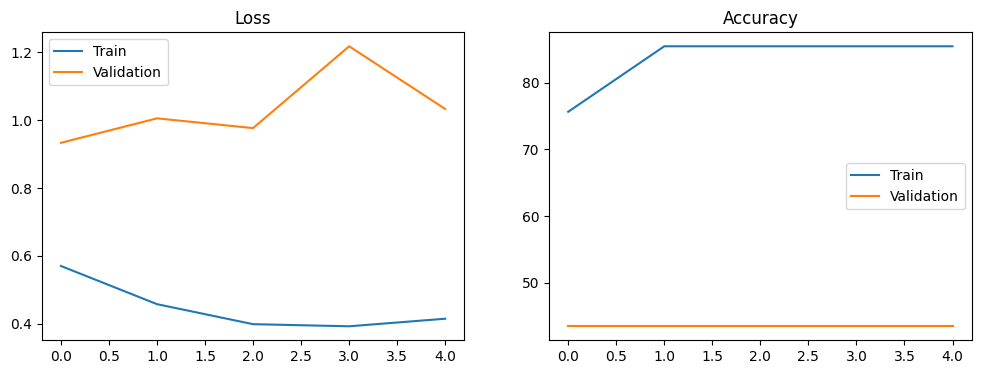

Acurácia da rede na base de teste: 43.44%


In [8]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [9]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mlva/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.4MB/s]


In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Epoch 1, Train Loss: 0.507, Train Accuracy: 76.92%
Epoch 1, Val Loss: 1.750, Val Accuracy: 43.44%


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 2, Train Loss: 0.386, Train Accuracy: 85.47%
Epoch 2, Val Loss: 0.986, Val Accuracy: 48.36%


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Epoch 3, Train Loss: 0.310, Train Accuracy: 87.61%
Epoch 3, Val Loss: 0.648, Val Accuracy: 65.57%


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 4, Train Loss: 0.253, Train Accuracy: 88.03%
Epoch 4, Val Loss: 0.728, Val Accuracy: 63.93%


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 5, Train Loss: 0.218, Train Accuracy: 91.03%
Epoch 5, Val Loss: 0.570, Val Accuracy: 68.85%
Treinamento concluído


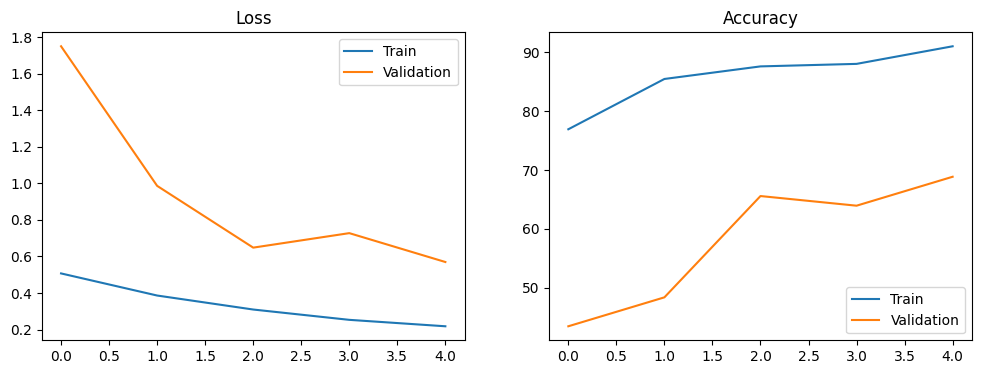

Acurácia da rede na base de teste: 68.85%


In [12]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(model, val_loader)

In [13]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

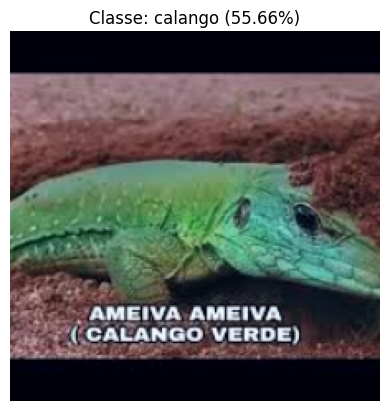

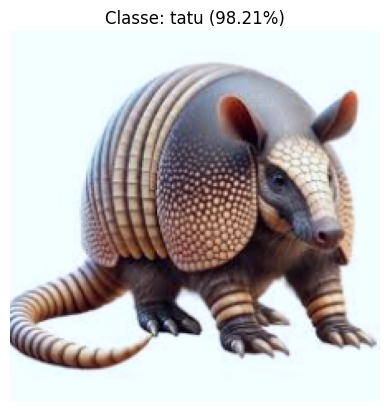

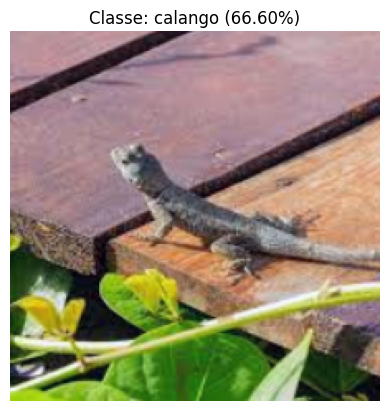

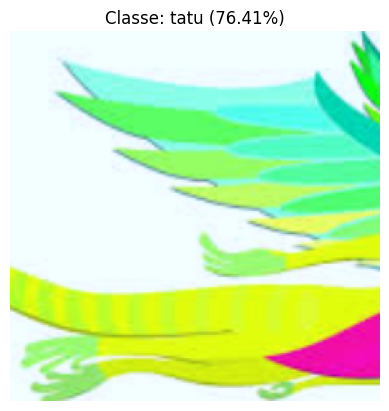

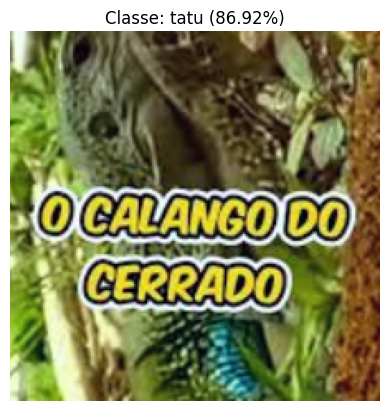

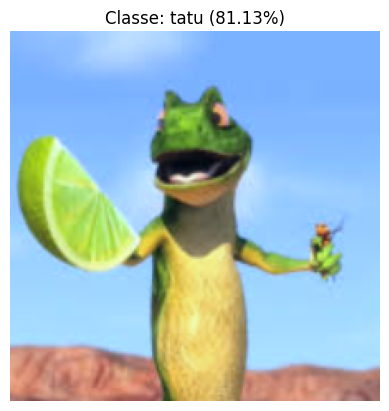

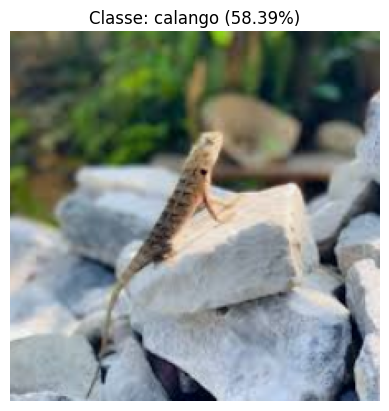

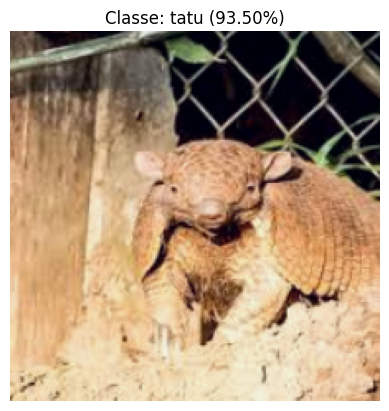

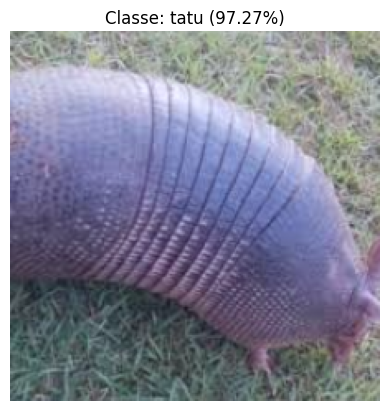

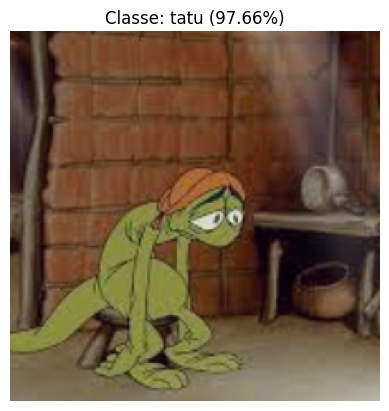

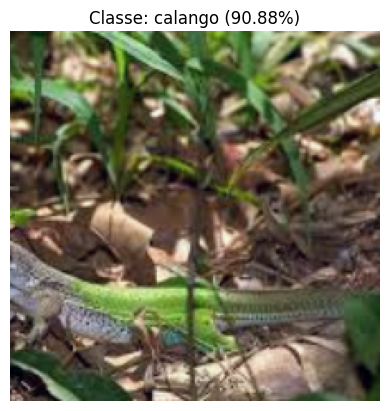

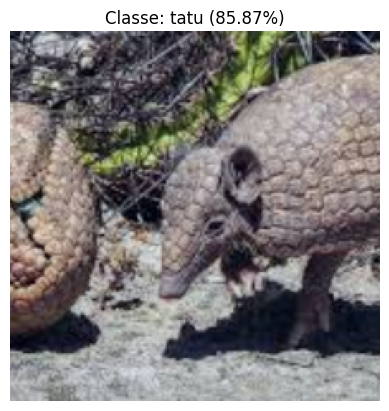

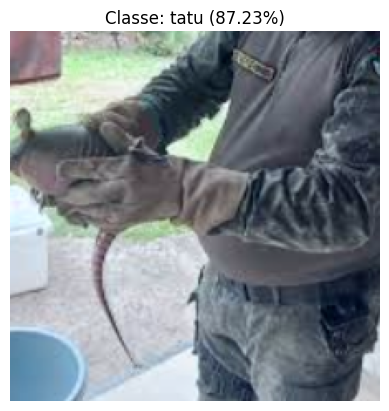

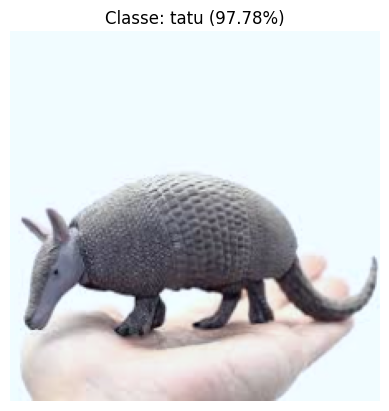

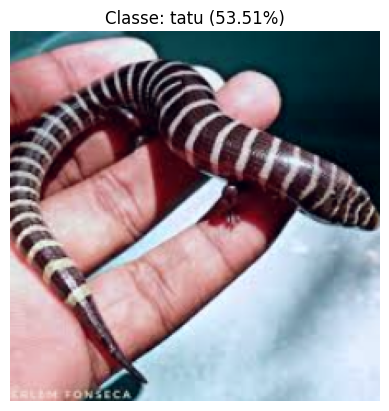

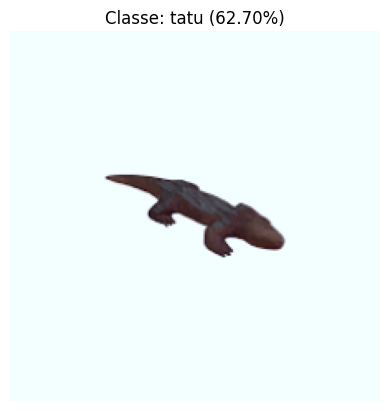

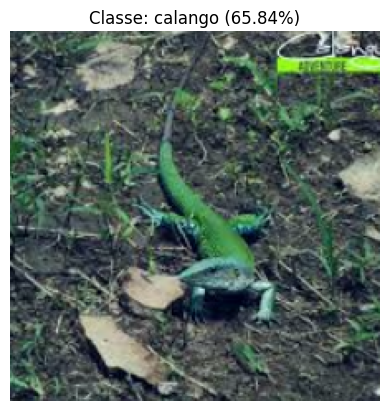

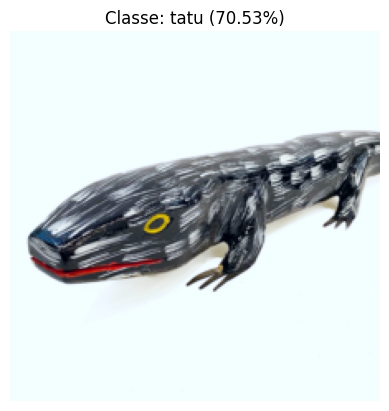

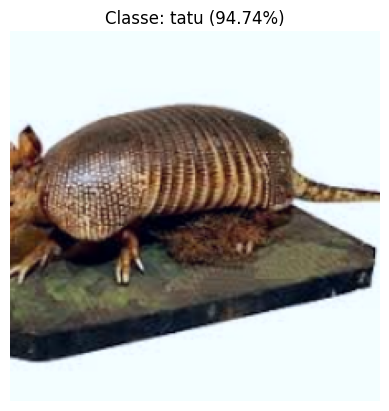

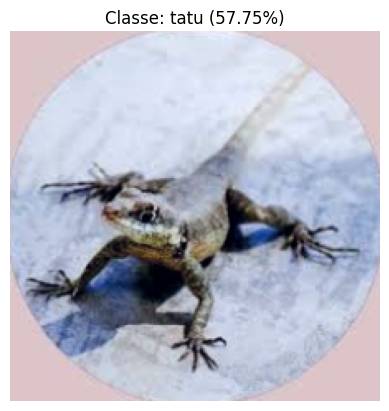

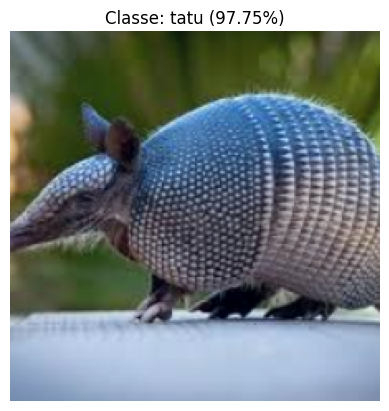

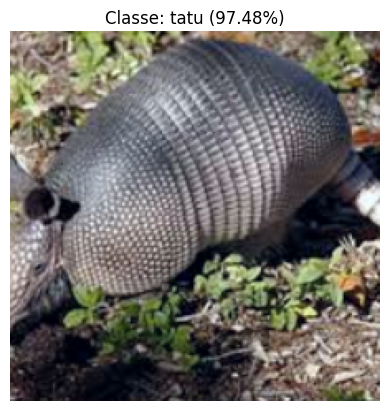

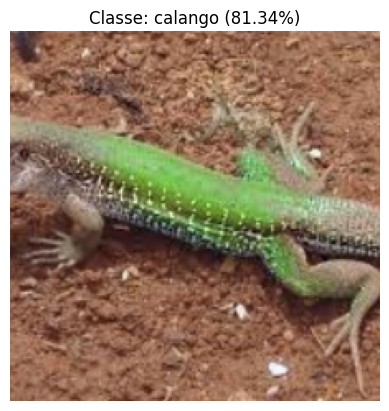

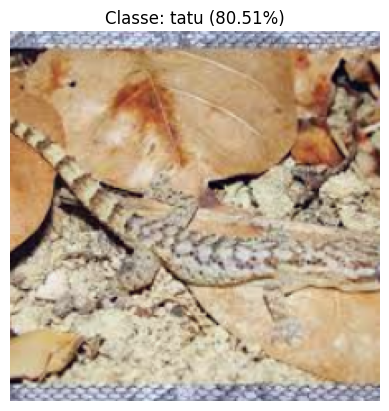

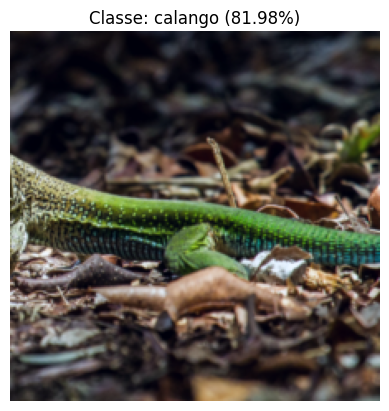

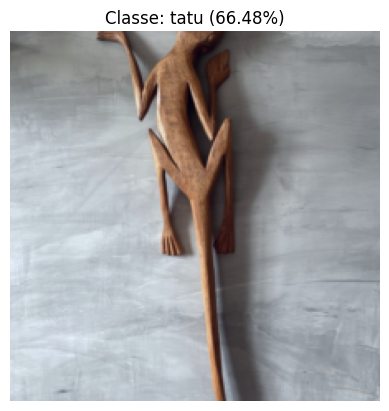

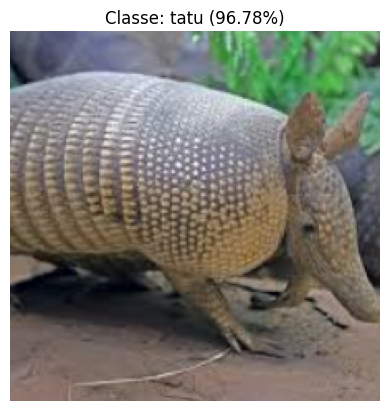

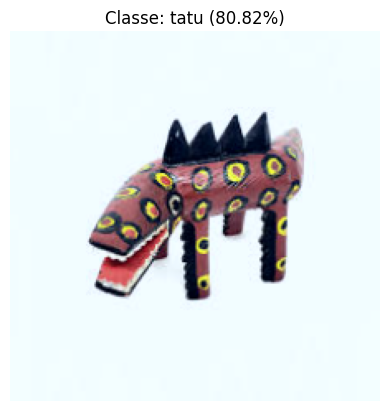

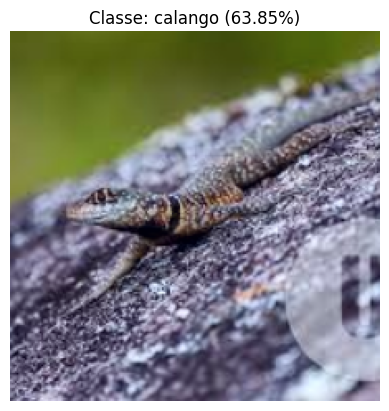

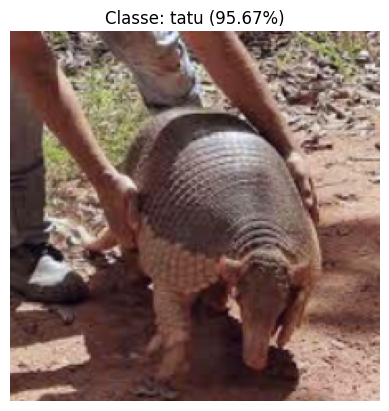

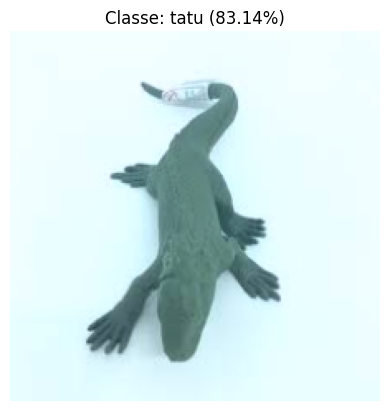

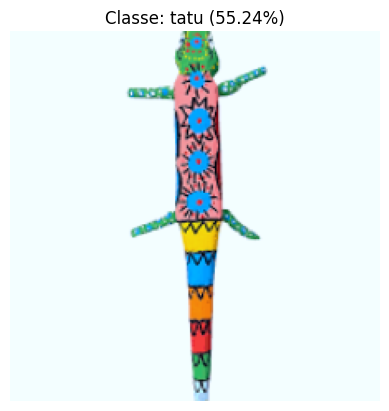

In [14]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Epoch 1, Train Loss: 0.189, Train Accuracy: 94.87%
Epoch 1, Val Loss: 0.476, Val Accuracy: 75.41%


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 2, Train Loss: 0.161, Train Accuracy: 94.87%
Epoch 2, Val Loss: 0.525, Val Accuracy: 72.95%


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Epoch 3, Train Loss: 0.156, Train Accuracy: 94.02%
Epoch 3, Val Loss: 0.582, Val Accuracy: 69.67%


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 4, Train Loss: 0.134, Train Accuracy: 95.30%
Epoch 4, Val Loss: 0.445, Val Accuracy: 77.05%


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 5, Train Loss: 0.129, Train Accuracy: 95.73%
Epoch 5, Val Loss: 0.394, Val Accuracy: 80.33%
Treinamento concluído


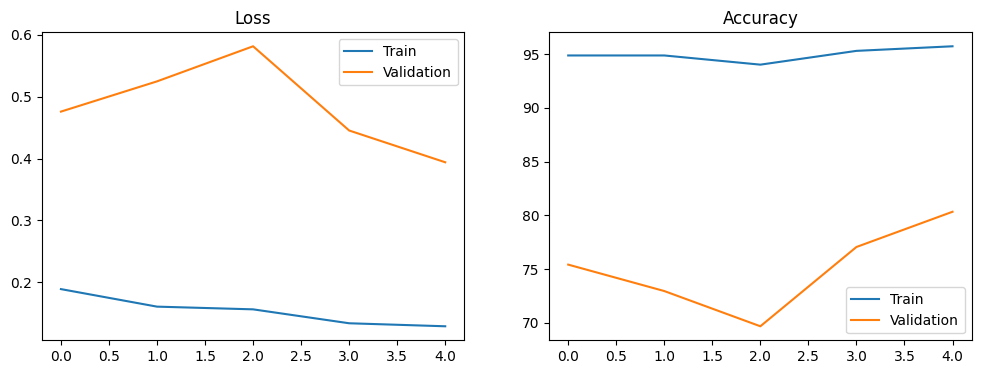

In [15]:
# Carregar novamente o dataset sem data augmentation
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)

# Treinando o modelo sem data augmentation
history_no_aug = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, device, num_epochs=5)

# Plotando as curvas de treinamento (sem data augmentation)
plot_history(history_no_aug)

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 1, Train Loss: 0.151, Train Accuracy: 95.30%
Epoch 1, Val Loss: 0.436, Val Accuracy: 78.69%


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 2, Train Loss: 0.187, Train Accuracy: 93.59%
Epoch 2, Val Loss: 0.551, Val Accuracy: 75.41%


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 3, Train Loss: 0.139, Train Accuracy: 95.73%
Epoch 3, Val Loss: 0.309, Val Accuracy: 84.43%


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Epoch 4, Train Loss: 0.138, Train Accuracy: 94.87%
Epoch 4, Val Loss: 0.412, Val Accuracy: 77.87%


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 5, Train Loss: 0.123, Train Accuracy: 95.30%
Epoch 5, Val Loss: 0.424, Val Accuracy: 77.87%
Treinamento concluído


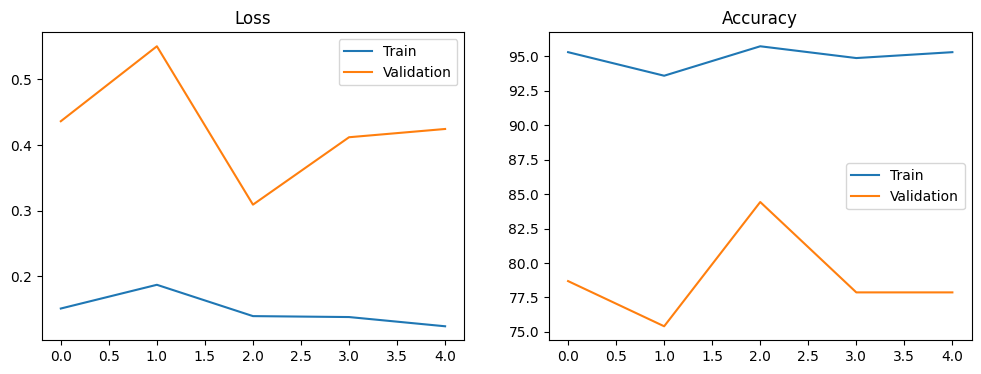

In [16]:
# Descongelar a camada layer4[1] para fine-tuning
for param in model.layer4[1].parameters():
    param.requires_grad = True

# Treinando o modelo com camadas adicionais descongeladas
history_fine_tune = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

# Plotando as curvas de treinamento
plot_history(history_fine_tune)


### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

100%|██████████| 8/8 [01:57<00:00, 14.64s/it]


Epoch 1, Train Loss: 0.793, Train Accuracy: 45.30%
Epoch 1, Val Loss: 0.793, Val Accuracy: 40.16%


100%|██████████| 8/8 [01:58<00:00, 14.85s/it]


Epoch 2, Train Loss: 0.775, Train Accuracy: 45.73%
Epoch 2, Val Loss: 0.792, Val Accuracy: 40.16%


100%|██████████| 8/8 [01:59<00:00, 14.95s/it]


Epoch 3, Train Loss: 0.820, Train Accuracy: 45.73%
Epoch 3, Val Loss: 0.793, Val Accuracy: 40.16%


100%|██████████| 8/8 [02:00<00:00, 15.09s/it]


Epoch 4, Train Loss: 0.832, Train Accuracy: 43.16%
Epoch 4, Val Loss: 0.794, Val Accuracy: 40.16%


100%|██████████| 8/8 [01:59<00:00, 14.96s/it]


Epoch 5, Train Loss: 0.842, Train Accuracy: 44.87%
Epoch 5, Val Loss: 0.792, Val Accuracy: 40.16%
Treinamento concluído


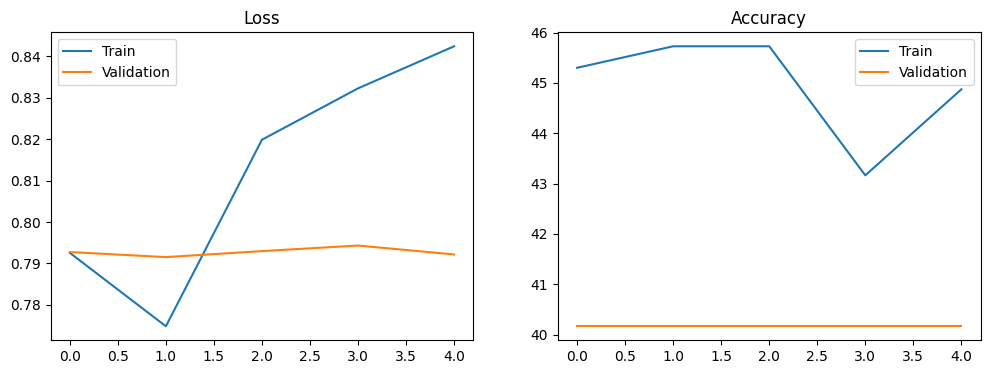

In [17]:
# Substituindo ResNet18 pelo modelo VGG16
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modificar a última camada para 2 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)

# Treinando o novo modelo
history_vgg16 = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

# Plotando as curvas de treinamento para o VGG16
plot_history(history_vgg16)
